In [1]:
from qiskit import QuantumCircuit, Aer, execute, IBMQ
from qiskit.providers import JobStatus
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.visualization import plot_histogram
from math import atan2, sqrt

In [2]:
basic_graph = { 'StayAtHome': ([], [.645, .355]), # P(A = 0), P(A = 1)
                'Testing': ([], [.62, .38]),  #P(B = 0), P(B = 1)
                #P(C=0|A=0,B=0), P(C=1|A=0,B=0), P(C=0|A=0,B=1), P(C=1|A=0,B=1), P(C=0|A=1,B=0), P(C=1|A=1,B=0), P(C=0|A=1,B=1), P(C=1|A=1,B=1)
                'Cases': (['StayAtHome','Testing'], [.818, .181, .8412, 0.158, 0.7068, 0.2931034, 0.23076, 0.7692])
              }

oil_graph = {'IR': ([], [.75, .25]), # From 2004.14803, Fig 10
         'SM': (['IR'], [.3, .7, .8, .2]), #P(0|!A), P(1|!A), P(0|A), P(1|A)
         'OI': ([], [.6, .4]),
         'SP': (['OI', 'SM'], [.9, .1, .5, .5, .4, .6, .2, .8])
        }


In [3]:
#TODO assertAlmostEqual(angle_from_probability(.8,.2), 2.2143)
def angle_from_probability(p1, p0):
    # From 2004.14803 equation 20
    return 2 * atan2(sqrt(p1), sqrt(p0))


In [4]:
def num_qbits_needed(graph):
    max_edges = -1 
    for state in graph:
        in_edges = len(graph[state][0]) # aka num of parents
        if in_edges > max_edges:
            max_edges = in_edges
    
    qbits = len(graph) + max_edges - 1 # equation (15)
    cbits = len(graph) # number of measurements
    return (qbits, cbits)

In [5]:
def run_circuit(circuit, output_file='results', draw_circuit=True, use_sim=True, use_noise=False, use_qcomp=False, shots=1024):
    if draw_circuit:
        #print(circuit.draw())
        %config InlineBackend.figure_format
        circuit.draw(output='mpl')

    if use_noise or use_qcomp:
        IBMQ.load_account()
        provider = IBMQ.get_provider('ibm-q')
        qcomp = provider.get_backend('ibmq_16_melbourne')

    if use_sim:
        simulator = Aer.get_backend('qasm_simulator')
        if use_noise:
            noise_model = NoiseModel.from_backend(qcomp)
            basis_gates = noise_model.basis_gates
            coupling_map = qcomp.configuration().coupling_map
            job = execute(circuit, backend=simulator, coupling_map=coupling_map, noise_model=noise_model, basis_gates=basis_gates, shots=shots)
        else:
            job = execute(circuit, backend=simulator, shots=shots)
        print(job.result().get_counts())
        plot_histogram(job.result().get_counts()).savefig(output_file+"-sim.png")


    if use_qcomp:
        job = execute(circuit, backend=qcomp, shots=shots)
        job_monitor(job)
        if(job.status() == JobStatus.ERROR):
            print("Error: Check with IBMQ")
        print(job.result().get_counts())
        plot_histogram(job.result().get_counts()).savefig(output_file+'-qcomp.png')
    return job.result()

In [6]:
# XXX Can we generalize this to C^nY gates
# ex: add_ccy(qc, [0,1,2], math.pi/3, 3)
def add_ccy(circuit, qbits, angle, ancillabit):
    # XXX Should we use this link instead of this function:
    # https://qiskit.org/documentation/tutorials/circuits_advanced/1_advanced_circuits.html
    circuit.barrier() # for visualization
    circuit.ccx(qbits[0], qbits[1], ancillabit)
    circuit.ry(angle/2,qbits[2])
    circuit.cx(ancillabit, qbits[2])
    circuit.ry(-angle/2, qbits[2] )
    circuit.cx(ancillabit, qbits[2])
    circuit.ccx(qbits[0], qbits[1], ancillabit)
    circuit.barrier() # for visualization
    

In [16]:
def create_circuit(graph):
    (qbits, cbits) = num_qbits_needed(graph)
    qc = QuantumCircuit(qbits, cbits)
    bit_assignment = {}
    ancillabits = []
    next_free_qbit = 0
    #Loop and find the parentless nodes, assign their rotations first
    for node in graph:
        if len(graph[node][0])==0:
            probs = graph[node][1]
            qc.ry(angle_from_probability(probs[1],probs[0]), next_free_qbit)
            bit_assignment[node] = next_free_qbit # keep track of what node is what qbit
            next_free_qbit += 1
    qc.barrier()

    #Loop and find each node that has all its parents complete and add it
    #TODO a topological sort first would save this unnessacary looping
    #XXX bad code, maybe the worst
    while True: # Loop until no states are added
        found_new = False
        for node in graph:
            if node not in bit_assignment:
                for parent in node[0]:  # get parents
                    if parent not in bit_assignment:
                        continue  # one of the parents needs to be processed first
                # Found a node we are ready to process
                found_new = True
                # TODO handle multi-bit states
                bit_assignment[node] = next_free_qbit # give it a qbit
                next_free_qbit += 1
                # FIXME hardcoded 1/2 parent, will generalize later
                if len(graph[node]) == 1:
                    print("1 parent not implemented") 
                    raise NotImplementedError
                if len(graph[node]) == 2:
                    # TODO this is gross
                    print(bit_assignment)
                    if(len(ancillabits) < 1): # need one more ancilla bit
                        ancillabits += [next_free_qbit]
                        next_free_qbit+=1
                    list_of_parents = graph[node][0]
                    list_of_probs = graph[node][1]
                    parent1_qbit = bit_assignment[list_of_parents[0]]
                    parent2_qbit = bit_assignment[list_of_parents[1]]
                    target_qbit = bit_assignment[node]
                    # |00>
                    qc.x(parent1_qbit)
                    qc.x(parent2_qbit)
                    # XXX ahhh this is horrible but will work for a demo
                    angle = angle_from_probability(list_of_probs[1], list_of_probs[0])
                    add_ccy(qc, [parent1_qbit,parent2_qbit,target_qbit], angle, ancillabits[0])
                    qc.x(parent1_qbit)
                    qc.x(parent2_qbit)
                    # |01>
                    qc.x(parent1_qbit)
                    angle = angle_from_probability(list_of_probs[3], list_of_probs[2])
                    add_ccy(qc, [parent1_qbit,parent2_qbit,target_qbit], angle, ancillabits[0])
                    qc.x(parent1_qbit)
                    # |10>
                    qc.x(parent2_qbit)
                    angle = angle_from_probability(list_of_probs[5], list_of_probs[4])
                    add_ccy(qc, [parent1_qbit,parent2_qbit,target_qbit], angle, ancillabits[0])
                    qc.x(parent2_qbit)
                    # |11>
                    angle = angle_from_probability(list_of_probs[7], list_of_probs[6])
                    add_ccy(qc, [parent1_qbit,parent2_qbit,target_qbit], angle, ancillabits[0])
        if not found_new:
            break # Completed a full loop over the nodes and all were added, done

    c_counter = 0
    for bit in bit_assignment:
        qc.measure(bit_assignment[bit], c_counter)
        c_counter += 1
    return qc

In [17]:
circuit = create_circuit(basic_graph)


{'StayAtHome': 0, 'Testing': 1, 'Cases': 2}
0 0
1 1
2 2


In [12]:
result = run_circuit(circuit, "lesser_model", shots=1024*8, use_sim=True, use_qcomp=False, use_noise=False)


{'000': 2727, '101': 544, '011': 246, '001': 1227, '010': 1665, '100': 587, '111': 866, '110': 330}


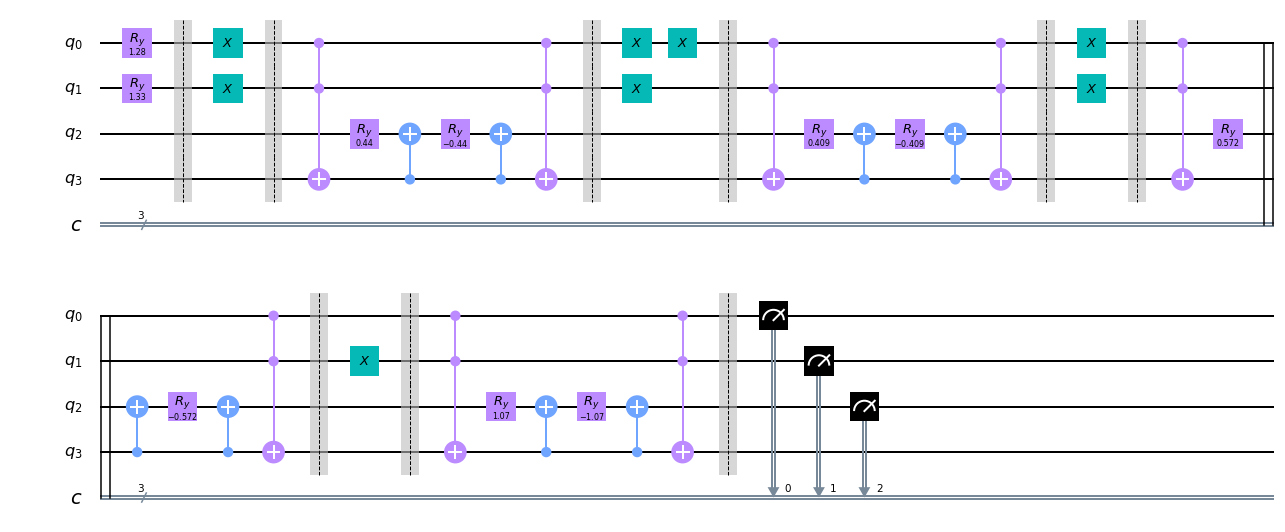

In [10]:
%config InlineBackend.figure_format
circuit.draw(output='mpl')

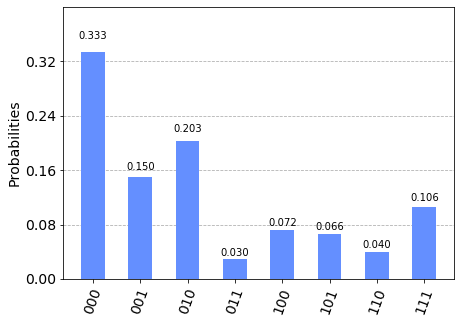

In [13]:
plot_histogram(result.get_counts())